# Evaluación de la pérdida de calidad del audio usando el codec OPUS

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · Agosto 2020 · 5 min read

---

## Resumen

La comunicación en la actualidad sería impensable sin el uso de codecs de audio digital para reducir el consumo del ancho de banda en las transmisiones de voz y música. Estos codecs utilizan algoritmos de compresión y limpieza del ruido para eliminar información del audio que el oído humano no escucha tan bien, para ello se utiliza un concepto llamado _bandas críticas_  y escala Bark (frecuencias bajas tienen mayor resolución que frecuencias bajas). Sin embargo, esta habilidad de compresión es precisamente una limitante para los sistemas de telemedicina que usan estetoscópios digitales, pues estos requieren analizar el audio sin pérdida de información. El propósito de este ipython notebook es evidenciar si en efécto, se produce una pérdida de la calidad del audio producida que podría afectar la calidad de la señal que podría procesar un algoritmo de reconocimiento de patrones. Los resultados están aún por determinarse...

# 1 Códec OPUS

Como decíamos anteriormente, el codificador de audio OPUS es el códec más usado en la actualidad para comprimir datos con pérdida, y ha evidenciado tener mejor rendimiento que el *MPEG layer-3* (MP3) y el *Advance Audio Coding* (AAC). Opus, como tal, no es un algoritmo de compresión, sino más bien una familia de ellos: por un lado utiliza el algoritmo [SILK](https://github.com/ploverlake/silk) (creado por Skype Limited) para comprimir voz, y por otro lado, utiliza el algoritmo *Constrained Energy Lapped Transform* (CELT) para comprimir música y voz de alta calidad [3]. Lo que hace es alternar entre uno y el otro, dependiendo de la ventana de análisis. El algoritmo SILK está basado en una técnica ampliamente conocida en el procesamiento del audio llamada Codificación por Predicción Lineal (LPC, por sus siglas en inglés), y el CELT está basado en otro algoritmo de compresión llamado OGG [4, 5]. Aún más, Opus no simplemente alterna entre SILK y CELT, sino que también tiene un modo "hibrido" de fabricación propia [11]. 

Para el lector experto, sobra recordar que todo algoritmo de compresión de audio se basa en conocimientos de una disciplina llamada psicoacústica para eliminar de la grabación aquellas frecuencias imperceptibles por el oido humano. Entre esos conocimientos están los siguientes conceptos:

* **Cóclea:** órgano en forma cónica que identifica las frecuencias y que se encuentra "arrollado" dentro del oído interno. Recibe estímulos del exterior mediante la ventana oval, y esta a su vez de los huesecillos conectados al tímpano.  

* **Escalas Bark y ERB:** modelos matemáticos para representar la resolución que tiene la cóclea respecto de las frecuencias del espectro audible: el oído humano realiza un mejor trabajo reconociendo la diferencia entre dos tonos graves que entre dos tonos agudos (como si tuviera una distribución logarítmica). La escala *Equivalent Rectangular Bandwidth* (ERB) es una versión mejorada de la escala Bark y su ecuación es $\text{ERB}(f)=21.4 \log_{10}{0.00437f+1}$ [9].

Populating the interactive namespace from numpy and matplotlib


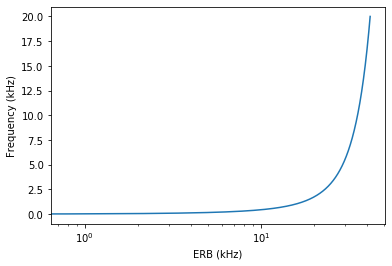

In [22]:
%pylab inline
import numpy as np

f = np.linspace(0,20000,1000)
erb = 21.4 * np.log10(0.00437*f+1)
pylab.plot(erb,f/1e3)
pylab.ylabel('Frequency (kHz)')
pylab.xlabel('ERB (kHz)')
pylab.xscale('log')
pylab.show()

* **Bandas críticas:** está relacionado al concepto anterior (pues existen más bandas críticas en las frecuencias bajas), pero se refiere a que la cóclea está segmentada en ventanas de tamaño variable que producen un efecto llamado enmascaramiento frecuencial.

TODO: encontrar dos tonos en la misma banda critica para crear un caso de prueba. https://en.wikipedia.org/wiki/Critical_band

* **Enmascaramiento frecuencial:** como ilustra la figura 1, es un fenómeno que ocurre cuando dos frecuencias caen en la misma banda crítica, entonces la frecuencia de mayor energía enmascarará (mediante su envolvente espectral) a la frecuencia de menor energía. 
<img src='img/QA_2-0112.jpeg' width='50%'>
Figura 1. Tomada de https://output.com/blog/9-sound-design-tips-to-hack-your-listeners-ears.  
  
* **Enmascaramiento temporal:** como ilustra la figura 2, es un fenómeno que ocurre cuando dos eventos ocurren lo suficientemente cercanos en el tiempo, el más fuerte enmascará al más débil si el segundo ocurre 10 ms antes (pre-enmascaramiento) o 30-60 ms después (post-enmascaramiento) que el primero [7].
<img src='img/3-Figure2-1.png' width=50%>
Figura 2. Tomada de https://d3i71xaburhd42.cloudfront.net/13674722d0e4fc8a6877773b25a62ee9850eb46a/3-Figure2-1.png.

Finalmente, cabe mencionar que OPUS trabaja con tasas de bits variable (de 8 kHz hasta 128 kHz) [3] y la figura 3 presenta la calidad reportada por la página del códec en términos de la escala *Mean Opinion Score* (MOS) [8].

<img src='img/qualityOpus.png' width='50%'>
Figura 3. Tomada de https://opus-codec.org/static/comparison/quality.svg.


# 2 Casos de prueba

Las mismas virtudes que hacen al algoritmo OPUS guardar espacio sin sacrificar la calidad del audio percibido por el oido humano pueden afectar la eficacia de un algoritmo de clasificación de patrones:

1. Al procesar dos tonos cercanos en frecuencia, el tono de energía más alta no debe enmascarar al de frecuencias más baja (enmascariento frecuencial).
2. Al procesar dos tonos cercanos en tiempo, el tono de energía más alta no debe enmascarar al de energía más baja (enmascariento temporal).
3. En general, el contenido de la magnitud espectral presente en un barrido de frecuencias debe mantenerse, sin que se agreguen o eliminen frecuencias.

## 2.1 Barrido de frecuencias

Para evaluar la distorción producida por el códec Opus, podemos usar un barrido de frecuencia de la forma [6]:
$$
F(t) = \Big(\frac{F_1-F_0}{T}\Big)t + F_0,
$$

para determinar cuales frecuencias han sido perdidas después del procesamiento. El rango de frecuencias a usar puede ser $[20, 22.5K]$ Hz (el rango conseguido comunmente con los equipos electrónicos comerciales). El barrido puede ser construido usando un senoidal de la forma $x[t] = A \sin(2\pi Ft)$.

Como el enmascaramiento frecuencial funciona para frecuencias cercanas, agregamos un tono adicional en la forma:

$$
x[t] = \sin(2\pi F_0 t) + \sin(2\pi 1.1 F_0 t).
$$

Populating the interactive namespace from numpy and matplotlib


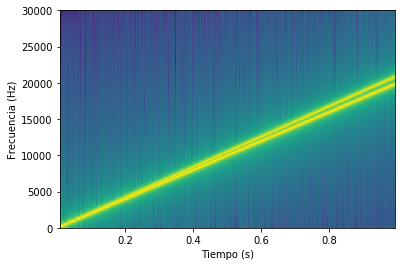

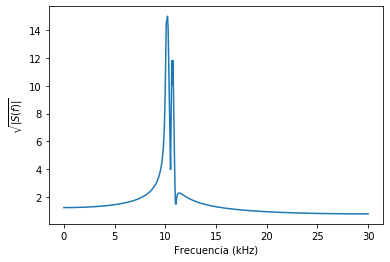

In [1]:
%pylab inline
from scipy.io import wavfile
from IPython.display import Audio
import numpy as np

def plotSpecgram(x,fs):
    # specgram
    fig, ax = pylab.subplots(nrows=1)
    ax.specgram(x, NFFT=1024, Fs=Fs, noverlap=900)
    pylab.xlabel('Tiempo (s)')
    pylab.ylabel('Frecuencia (Hz)')
    pylab.show()
    
def plotFFT(x,fs):
    pylab.figure()
    N2=int(len(x)/2)
    f = np.linspace(0,fs/2,N2)/1000
    X = np.sqrt(np.abs(np.fft.fft(x)[0:N2]))
    pylab.plot(f, X)
    X[0] = 0 # remove DC value
    pylab.xlabel('Frecuencia (kHz)')
    pylab.ylabel('$\sqrt{|S(f)|}$')
    pylab.show()

rango = [20.0, 20000.0] # el rango promedio de audicion humano en Hz
Fs = rango[1]*3 # 2 veces la freq. maxima para cumplir con el teorema del muestreo
T = 1.0 # segundos (t1-t0)

N = int(T*Fs)
n = np.arange(0,N)
F0 = (rango[1]-rango[0])*n/N + rango[0]
x = np.sin(np.pi*F0/Fs*n) + 0.5*np.sin(np.pi*1.05*F0/Fs*n) # f=F0/Fs (discrete frequency)

plotSpecgram(x,Fs)
plotFFT(x[30000:31000],Fs)

wavfile.write('/tmp/barrido_20_20k.wav',int(Fs),x)
Audio(x, rate=Fs) 

Se observan dos rectas correspondientes a los barridos de frecuencia en $F_0$ y $1.1 F_0$, y el resto del espectro está limpio. 

Se elegió graficar la FFT en un instante donde los tonos se ubicaban cerca de los 10 Hz (entre las 30000 y 31000 muestras), pues una banda crítica está ubicada en esa frecuencia [10].  

# 2.2 Ejecución de los casos de prueba

Ahora, realizamos el procesamiento con Opus usando, 8 Kbps, la tasa de bits narroband en la figura 1 que tambien corresponde a la calidad de una video llamada 1:1 segun https://www.reviews.org/internet-service/how-much-data-does-zoom-use/:

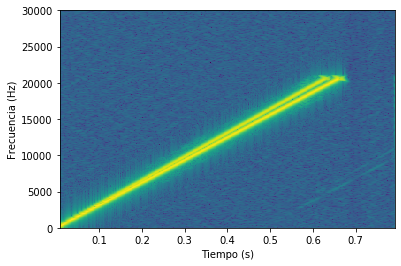

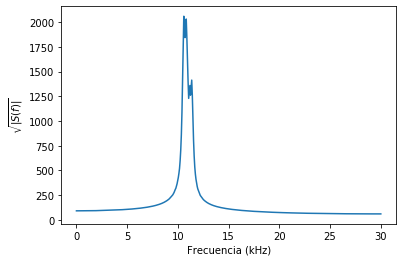

In [10]:
def readPlayVisualizeFile(inputFile):
    fs, x = wavfile.read(inputFile)
    y = np.array(x)/max(x)
    plotSpecgram(x,fs)
    return fs, x

# MP3
!lame --quiet /tmp/barrido_20_20k.wav /tmp/opusEnc.mp3
!lame --quiet --decode /tmp/opusEnc.mp3 /tmp/opusDec.wav

# OPUS
#!sudo apt-get install opus-tools
#!ffmpeg -loglevel error -y -i /tmp/barrido_20_20k.wav -qscale 0 /tmp/wavRaw.wav # same quality
#!opusenc --quiet --bitrate 8 /tmp/wavRaw.wav /tmp/opusEnc.opus
#!opusdec --quiet /tmp/opusEnc.opus /tmp/opusDec.wav

fs, x = readPlayVisualizeFile('/tmp/opusDec.wav')
plotFFT(x[20000:21000],Fs)

Audio(x, rate=fs)

**Nota:** use audifonos para apreciar mejor la calidad el audio.

Como se observa, las frecuencias más altas que 5K Hz fueron truncadas completamente. Probemos ahora con 128 kbps (fullband stereo) a ver si la calidad mejora.

Skipping chunk of type "LIST", length 26


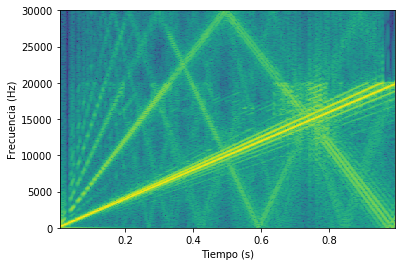

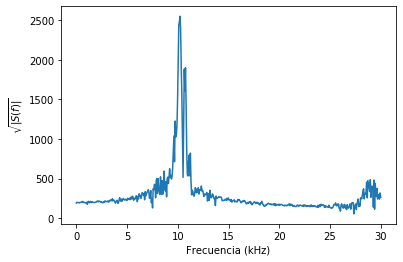

In [5]:
!ffmpeg -loglevel error -y -i /tmp/barrido_20_20k.wav -qscale 0 /tmp/wavRaw.wav # same quality
!opusenc --quiet --bitrate 64 /tmp/wavRaw.wav /tmp/opusEnc.opus
!opusdec --quiet /tmp/opusEnc.opus /tmp/opusDec.wav
fs, x = readPlayVisualizeFile('/tmp/opusDec.wav')
plotFFT(x[30000:31000],Fs)

Audio(x, rate=fs)

Observamos que el contenido frecuencial ha sufrido muchos cambios, entre ellos, se introdujeron frecuencias parásitas producto del aliasing o del [clipping](https://en.wikipedia.org/wiki/Clipping_(audio)), hay al menos 4 rectas principales en lugar de 2, también parece que se ha aplicado un filtro pasabajas con frecuencia de corte 20K Hz. Entonces sí que el codec Opus introduce distorsiones. Esto significa que si se aplica reconocimiento de patrones a una grabación procesada por Opus, el clasificador tendría información con mucho más ruido que con una grabación en formato WAV. 

Aún se pueden apreciar los dos tonos ubicados cerca de 10K Hz, por lo que la distorsión introducida para el Opus no ha sido mucha. Cabe preguntarse, ¿esto sucede porque se está usando CELT en lugar de SILK? ¿Podría forzarse usar SILK?

# 3 Analizando una grabación real

Ahora realicemos una prueba procesando una grabación empleada en el reconocimiento de sonidos del cuerpo (una disciplina llamada auscultación). Para tomamos una grabación del sitio https://www.kaggle.com/vbookshelf/respiratory-sound-database. 

In [126]:
fs, x = readPlayVisualizeFile('./wav/107_3p2_Tc_mc_AKGC417L_2.wav')
plotFFT(x,fs)

Audio(x, rate=fs)

<Figure size 432x288 with 0 Axes>

Observamos que hay energía alta en el rango $[0,1.5]$ y $[7.5,9.5]$ kHz.

Al parecer, la cantidad de bits usados tiene un efecto directamente proporcional sobre la frecuencia de corte. Además, observamos que la energía del rango $[0,1.5]$ se dispersó ahora por $[0,4.5]$ kHz y que el pic en $[7.5,9.5]$ kHz desapareció.

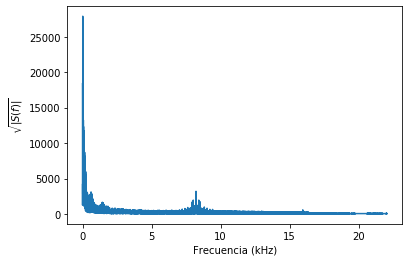

In [13]:
# MP3
!lame --quiet ./wav/107_3p2_Tc_mc_AKGC417L_2.wav /tmp/opusEnc.mp3
!lame --quiet --decode /tmp/opusEnc.mp3 /tmp/opusDec.wav

# OPUS
#!ffmpeg -loglevel error -y -i ./wav/107_3p2_Tc_mc_AKGC417L_2.wav -qscale 0 /tmp/wavRaw.wav # same quality
#!opusenc --quiet --bitrate 8 /tmp/wavRaw.wav /tmp/opusEnc.opus
#!opusdec --quiet /tmp/opusEnc.opus /tmp/opusDec.wav

fs, x = readPlayVisualizeFile('/tmp/opusDec.wav')
plotFFT(x,fs)

Audio(x, rate=fs)

# 4 Conclusiones

En términos psicoacústicos, la distorsión del OPUS no parece estar en el enmascaramiento de frecuencias sino más bien en la presencia de contenido frecuencial que no estaba antes, producto de un fenómeno llamado clipping. Igualmente, esto podría afectar el rendimiento de un algoritmo de reconocimiento de patrones.


# Referencias
1. Colaboradores de Wikipedia. Códec de audio [en línea]. Wikipedia, La enciclopedia libre, 2020 [fecha de consulta: 4 de noviembre del 2020]. Disponible en <https://es.wikipedia.org/w/index.php?title=C%C3%B3dec_de_audio&oldid=129362034>. 
2. Hong  Kong  Polytechnic  University. Department of Electronic and Information Engineering. Perceptual Coding and MP3. Disponible en <http://www.eie.polyu.edu.hk/~enyhchan/DAP-lab-PModel-v3.pdf>.
3. López Monfort José Javier. Opus codec | 22/23 | UPV. Universitat Politècnica de València - UPV. Disponible en <https://youtu.be/2-yv1bCDL94>. 
4. Wikipedia contributors. (2020, October 11). SILK. In Wikipedia, The Free Encyclopedia. Retrieved 15:18, November 8, 2020, from https://en.wikipedia.org/w/index.php?title=SILK&oldid=982904860
5. Wikipedia contributors. (2020, November 2). Linear predictive coding. In Wikipedia, The Free Encyclopedia. Retrieved 15:22, November 8, 2020, from https://en.wikipedia.org/w/index.php?title=Linear_predictive_coding&oldid=986664067
6. EPFL. Room impulse responses. Ultima vez consultado el 27 Dec 2020 en: https://nbviewer.jupyter.org/github/LCAV/SignalsOfTheDay/blob/master/Room_Acoustics/Room%20Impulse%20Response.ipynb
7. López Monfort José Javier. Enmascaramiento Temporal | 4/23 | UPV. Disponible en <https://youtu.be/7NQvDoZMBM8> (consultado por última vez el 3 de Enero de 2021).
8. International Telecomunication Union (ITU-T). P.800.1, MOS.
9. Julius O. Smith III, Jonathan S. Abel. Equivalent Rectangular Bandwidth. Center for Computer Research in Music and Acoustics (CCRMA), Stanford University. Disponible en <https://ccrma.stanford.edu/~jos/bbt/Equivalent_Rectangular_Bandwidth.html> (consultado por última vez el 5 de Enero de 2021).
10. LCAV. Python MP3 encoder. Disponible en <https://github.com/LCAV/MP3Lab/blob/master/mp3python.ipynb> (consultado por última vez el 6 de Enero de 2021).
11. XIPH ORG. OpusFAQ. Disponible en <https://wiki.xiph.org/OpusFAQ#Why_not_keep_the_SILK_and_CELT_codecs_separate.3F> (consultado por última vez el 6 de Enero de 2021).

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br/>Este obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">licencia de Creative Commons Reconocimiento-NoComercial-SinObraDerivada 4.0 Internacional</a>. El sitio [juanfonsecasolis.github.io](https://juanfonsecasolis.github.io) es un blog dedicado a la investigación independiente en temas relacionados al procesamiento digital de señales. Para reutilizar este artículo y citar las fuente por favor utilice el siguiente Bibtex:

```
@online{Fonseca2020,
  author = {Juan M. Fonseca-Solís},
  title = { Pruebas por pares o pairwise testing},
  year = 2020,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.pairwisetesting.html},
  urldate = {}
}
```